want to roll a FWTD. Will stick a FWTD at both ends of a rigid beam that can rotate freely

### Preamble

In [1]:
import sympy as sym
import sympy.physics.mechanics as me
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '..\..'))
import sympyTransforms as symt
import custom_plot_objects as cpo
import FwtModels as fm
import FwtModels.dof2 as dof2
import FwtModels.RollingModel as rm
import FwtModels.AeroModels as ams

me.mechanics_printing()

### Define the Model

#### Create Parameter instance

In [2]:
half = sym.Rational(1,2)

p = fm.FwtParameters(3)

# fwt params
p.Lambda = fm.FwtVariable(np.deg2rad(10),'Lambda') # flare angle
p.y_f = sym.Symbol('y_f')# spanwise location
    
# Attitude Parmas
p.rho = fm.FwtVariable(1.225,'rho') # density
p.V = fm.FwtVariable(10,'V') # velocity
p.g  = fm.FwtVariable(9.81,'g') # gravity
p.alpha_r = fm.FwtVariable(np.deg2rad(3),'alpha_r') # root AoA

# Main Wing Parameter
p.a_w = fm.FwtVariable(2*np.pi,'a_w') # C_L of wing
p.y_w = sym.Symbol('y_w') # spanwise location


# Create some global parameters
p.c = fm.FwtVariable(0.06,'c') # chord of wing
p.m_t = fm.FwtVariable(2,'m_t') # wing total mass
p.s_t = fm.FwtVariable(1,'s_t') # wing total span
p.sigma = fm.FwtVariable(0.2,'sigma') # FWT as percentage of total span
#p.f = fm.FwtVariable(2,'f') # initial freqency


# Set dependent expressions
p.m_w = p.m_t*(sym.Integer(1)-p.sigma) # mass of inner wing
p.s_w = p.s_t*(sym.Integer(1)-p.sigma) # span of main wing
p.m_f = p.m_t*p.sigma*half # mass of each FWT
p.s_f = p.s_t*p.sigma*half # span of each FWT

p.a_f_0 = fm.FwtVariable(np.pi*2,'a_f0')
p.a_f_grad = fm.FwtVariable((2*np.pi)/1*0.2*0.5,'a_f_grad')
p.a_f = p.a_f_0 - p.a_f_grad*p.y_f


p.I_xx_f = sym.Rational(1,12)*p.m_f*p.s_f**2 # inertia of FWT (uniform bar)
p.I_xx_w = sym.Rational(1,12)*p.m_w*p.s_w**2 # inertia of wing (uniform bar)
p.l_f = p.s_f*half # location of FWT CoM from Hinge
p.l_w = 0 # location of main wing CoM

p.aoa_rhs = fm.FwtVariable(0,'alpha_rhs') # chord of wing
p.aoa_lhs = fm.FwtVariable(0,'alpha_lhs') # chord of wing

#p.aoadot_rhs = fm.FwtVariable(0,'alphadot_rhs') # chord of wing
#p.aoadot_lhs = fm.FwtVariable(0,'alphadot_lhs') # chord of wing

#p.k_w = (p.f*2*sym.pi)**2*(p.m_t) # set inner wing Freq to inner_freq

#### Create Transforms

system has 3 degrees of freedom:

q[0] - rotation about the base of the spring (roll)
q[1] - plunging motion
q[2] - FWT fold angle



In [3]:
wing_frame = symt.HomogenousTransform().R_x(p.q[0]).R_y(p.alpha_r)
rhs_fwt_frame = wing_frame.Translate(0,p.s_w*half,0).R_x(p.q[1])  # RHS Fwt Frame
lhs_fwt_frame = wing_frame.Translate(0,-p.s_w*half,0).R_x(-p.q[2])  # RHS Fwt Frame

M_fwt = fm.MassMatrix(p.m_f,I_xx = p.I_xx_f)
M_w = fm.MassMatrix(p.m_w,I_xx = p.I_xx_w)

bar_fwt_rhs = fm.RigidElement(rhs_fwt_frame.Translate(0,p.l_f,0),M_fwt)
bar_fwt_lhs = fm.RigidElement(lhs_fwt_frame.Translate(0,-p.l_f,0),M_fwt)
bar_wing = fm.RigidElement(wing_frame,M_w)

# Gravitational Forces
fwt_GravityForces_rhs = ams.GravityModel(p,rhs_fwt_frame.Translate(0,p.l_f,0),sym.Matrix([0,0,p.g*p.m_f]))
fwt_GravityForces_lhs = ams.GravityModel(p,lhs_fwt_frame.Translate(0,-p.l_f,0),sym.Matrix([0,0,p.g*p.m_f]))
wing_GravityForces = ams.GravityModel(p,wing_frame,sym.Matrix([0,0,p.g*p.m_w]))
#Aero Forces
rhs_fwt_AeroForces = ams.AeroModelv3(p,rhs_fwt_frame.Translate(0,p.y_f,0),p.a_f,(p.y_f,0,p.s_f),p.aoa_rhs,0,0,0,0)
lhs_fwt_AeroForces = ams.AeroModelv3(p,lhs_fwt_frame.Translate(0,-p.y_f,0),p.a_f,(p.y_f,0,p.s_f),p.aoa_lhs,0,0,0,0)

In [4]:
wing_frame_aero = wing_frame.Translate(0,p.y_w,0)
wing_AeroForces = ams.AeroModelv3(p,wing_frame_aero,p.a_w,(p.y_w,-p.s_w*half,p.s_w*half),p.alpha_r,0,0,0,0)

Forcing = ams.ForcingFunction(None) 

#compistie force
CompositeForce = ams.CompositeForce(p,[fwt_GravityForces_rhs,fwt_GravityForces_lhs,
                                     rhs_fwt_AeroForces,lhs_fwt_AeroForces,
                                     wing_AeroForces,Forcing])
# potential energy
U = 0

In [5]:
# create instance of the model
sm = rm.SymbolicModel(U,[bar_fwt_rhs,bar_fwt_lhs,bar_wing],p,ExtForces = CompositeForce)

## create masses 

In [7]:
tmax, dt = 120, 0.01
# Initial conditions: theta, dtheta/dt, L, dL/dt

#params = p.GetNumericTuple()

p.a_f_0.value = np.pi*2
p.a_f_grad.value = ((2*np.pi)/1*0.2*0.5)*1
p.m_t.value = 0.3

#set velocity and alpha_r funcs
def Vfunc(t,x):
    return 20

def arfunc(t,x):
    return np.deg2rad(0)
    #return np.deg2rad(5)+np.sin(2*np.pi*1*t)*np.deg2rad(5)
    
def FwtAoA(Lambda,foldAngle,root_aoa):
    # get velocity vector in FWT frame
    return np.arctan(np.sin(Lambda)*np.sin(foldAngle)) + root_aoa*np.cos(foldAngle)

def FwtAoA(t,foldAngle,root_aoa):
    Lambda = p.Lambda.value
    # get velocity vector in FWT frame
    v_x = (np.sin(Lambda)**2*np.cos(root_aoa)*np.cos(foldAngle) - np.sin(Lambda)**2*np.cos(root_aoa) - np.sin(Lambda)*np.sin(root_aoa)*np.sin(foldAngle) + np.cos(root_aoa))
    v_z = (np.sin(Lambda)*np.sin(foldAngle)*np.cos(root_aoa) + np.sin(root_aoa)*np.cos(foldAngle))
    return np.arctan(v_z/v_x)

def aoa_eff(t,x):
    return FwtAoA()

def Force(tup,x,t):
    val = 0.08
    if t<5:
        return np.array([[0],[0],[0]])
    if t<10:
        return np.array([[val*(t-5)/5],[0],[0]])
    return np.array([[val],[0],[0]])

Forcing.Forcingfunction = Force
    

p.V.value = Vfunc
p.alpha_r.value = arfunc
p.aoa_rhs.value = lambda t,x:FwtAoA(t,x[2],arfunc(t,x))
p.aoa_lhs.value = lambda t,x:FwtAoA(t,x[4],arfunc(t,x))


#y0 = [1.57,0,0,0,0,0]
#y0 = [1.5,0,0.02,0]
ts = np.arange(0, tmax+dt, dt)

#constraints = [0,0,np.NaN,np.NaN,np.NaN,np.NaN]
y0 = [0,0,0.18,0,0.18,0]



#constraints = [np.NaN,np.NaN,0,0,0,0]
#y0 = [0,0,0.0,0,0.0,0]


constraints = [np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN]

def objectiveDeriv(t,y):
    deriv = list(sm.deriv(t,y,p.GetNumericTuple(y,t)))
    return tuple(np.where(np.isnan(constraints),deriv,constraints))

Text(0.5, 0, 't [s]')

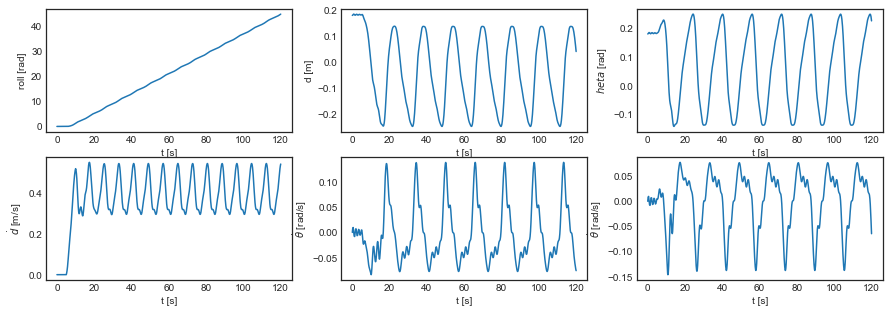

In [8]:
yData = solve_ivp(objectiveDeriv,(0,tmax),y0)

# interpolate data onto a uniform time grid

yi = yData.y
t = yData.t

plt.style.use('seaborn-white')
    
fig, axes = plt.subplots(2,3,figsize=(15,5))

# roll plot
axes[0][0].plot(t,yi[0])
axes[0][0].set_ylabel('roll [rad]')
axes[0][0].set_xlabel('t [s]')

# d plot
axes[0][1].plot(t,yi[2])
axes[0][1].set_ylabel('d [m]')
axes[0][1].set_xlabel('t [s]')

# theta plot
axes[0][2].plot(t,yi[4])
axes[0][2].set_ylabel('$\theta$ [rad]')
axes[0][2].set_xlabel('t [s]')


# ddot plot
axes[1][0].plot(t,yi[1])
axes[1][0].set_ylabel('$\dot{d}$ [m/s]')
axes[1][0].set_xlabel('t [s]')

# thetadot plot
axes[1][1].plot(t,yi[3])
axes[1][1].set_ylabel(r'$\dot{\theta}$ [rad/s]')
axes[1][1].set_xlabel('t [s]')

# thetadot plot
axes[1][2].plot(t,yi[5])
axes[1][2].set_ylabel(r'$\dot{\theta}$ [rad/s]')
axes[1][2].set_xlabel('t [s]')

Text(0.5, 0, 't [s]')

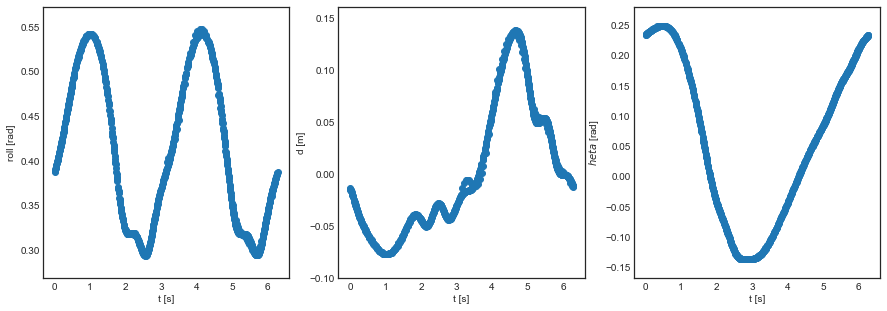

In [9]:
fig, axes = plt.subplots(1,3,figsize=(15,5))

# roll plot
ind = yi[0]>np.pi

axes[0].scatter(yi[0][ind]%(2*np.pi),yi[1][ind])
axes[0].set_ylabel('roll [rad]')
axes[0].set_xlabel('t [s]')

# d plot
axes[1].scatter(yi[0][ind]%(2*np.pi),yi[3][ind])
axes[1].set_ylabel('d [m]')
axes[1].set_xlabel('t [s]')

# theta plot
axes[2].scatter((yi[0][ind])%(2*np.pi),yi[4][ind])
axes[2].set_ylabel('$\theta$ [rad]')
axes[2].set_xlabel('t [s]')


In [9]:
ind

array([False, False, False, ...,  True,  True,  True])

In [10]:
yi[1][ind]

array([0.39873254, 0.40238514, 0.40647904, 0.41078669, 0.41618603,
       0.42409366, 0.43536372, 0.44569409, 0.4575632 , 0.47132522,
       0.48575905, 0.49640824, 0.50695158, 0.52037232, 0.53316119,
       0.54014688, 0.54513826, 0.54742427, 0.54765732, 0.54550545,
       0.54053193, 0.53277243, 0.524581  , 0.51435202, 0.50147053,
       0.48649314, 0.47296549, 0.45835891, 0.44211575, 0.42516065,
       0.41100915, 0.39701932, 0.38280366, 0.36926113, 0.35893255,
       0.34965204, 0.34114829, 0.33391333, 0.32913746, 0.32533977,
       0.32221389, 0.31972121, 0.31821121, 0.31678278, 0.31510374,
       0.31304189, 0.31057214, 0.30871229, 0.30638454, 0.30342103,
       0.30015236, 0.29837413, 0.29694546, 0.29611179, 0.29636441,
       0.29808132, 0.30078421, 0.30482111, 0.31012271, 0.31547026,
       0.32136519, 0.32820516, 0.33551705, 0.34156092, 0.34762583,
       0.35410418, 0.36047486, 0.36736437, 0.37463808, 0.38072099,
       0.38728775, 0.3950543 , 0.40382355, 0.41194647, 0.42083